#Определение стоимости автомобилей

**Цель проекта**
Цель проекта заключается в разработке модели машинного обучения, способной точно определять рыночную стоимость автомобилей с пробегом на основе их технических характеристик и комплектации. Проект направлен на создание модели для сервиса «Не бит, не крашен», которое поможет пользователям оценить стоимость своих автомобилей и привлечет новых клиентов.

**Задача проекта**
Определить модель с наилучшим балансом между точностью предсказания и скоростью работы.


**План проекта**

1. [Подготовка данных](#scrollTo=AK_f145zRlNG)
2. [Исследовательский анализ данных](#scrollTo=GD6PUOaaRlNM)
3. [Корреляционный анализ](#scrollTo=YuAqD2aJRlNW)
4. [Подготовка данных](#scrollTo=-vqbOmIwRlNX)
5. [Обучение модели](#scrollTo=3WPK8_ayRlNb)
6. [Анализ модели](#scrollTo=0JrQq3cGRlNc)
7. [Общий вывод](#scrollTo=ylj5cY_EUPiC&line=1&uniqifier=1)

## Подготовка данных

### Загрузка данных

In [ ]:
!pip install --upgrade numpy scipy numba -q

In [ ]:
!pip install phik -q

In [ ]:
!pip install scikit-learn==1.4.2 -q

In [ ]:
!pip install scipy==1.9.1 -q

In [ ]:
!pip install matplotlib==3.5.2 -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import lightgbm as lgb
import time

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler,LabelEncoder
from sklearn.preprocessing import OneHotEncoder,  MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score, KFold

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import f1_score,  mean_squared_error, mean_absolute_error, r2_score,  make_scorer
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
TEST_SIZE = 0.25
RANDOM_STATE = 42

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/datasets/autos.csv')

In [ ]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
  <h3>Описание данных</h3>
  <p><strong>Признаки</strong></p>
  <ul>
    <li><strong>DateCrawled</strong> — дата скачивания анкеты из базы</li>
    <li><strong>VehicleType</strong> — тип автомобильного кузова</li>
    <li><strong>RegistrationYear</strong> — год регистрации автомобиля</li>
    <li><strong>Gearbox</strong> — тип коробки передач</li>
    <li><strong>Power</strong> — мощность (л. с.)</li>
    <li><strong>Model</strong> — модель автомобиля</li>
    <li><strong>Kilometer</strong> — пробег (км)</li>
    <li><strong>RegistrationMonth</strong> — месяц регистрации автомобиля</li>
    <li><strong>FuelType</strong> — тип топлива</li>
    <li><strong>Brand</strong> — марка автомобиля</li>
    <li><strong>Repaired</strong> — была машина в ремонте или нет</li>
    <li><strong>DateCreated</strong> — дата создания анкеты</li>
    <li><strong>NumberOfPictures</strong> — количество фотографий автомобиля</li>
    <li><strong>PostalCode</strong> — почтовый индекс владельца анкеты (пользователя)</li>
    <li><strong>LastSeen</strong> — дата последней активности пользователя</li>
  </ul>
  <p><strong>Целевой признак</strong></p>
  <ul>
    <li><strong>Price</strong> — цена (евро)</li>
  </ul>
</div>

In [ ]:
def report_missing_values(df):
    val_count = df.isnull().sum()
    val_percent = (df.isnull().sum() / len(df)) * 100
    info = pd.DataFrame({
        'Количество пропущенных значений': val_count,
        'Процент пропущенных значений': val_percent
    })
    info = info[info['Количество пропущенных значений'] > 0]
    if not info.empty:
        print("Информация о пропущенных значениях:\n")
        print(info)
    else:
        print("Пропущенные значения отсутствуют.")

In [ ]:
report_missing_values(df)

Информация о пропущенных значениях:

             Количество пропущенных значений  Процент пропущенных значений
VehicleType                            37490                     10.579368
Gearbox                                19833                      5.596709
Model                                  19705                      5.560588
FuelType                               32895                      9.282697
Repaired                               71154                     20.079070


In [ ]:
date_columns = ['DateCrawled' , 'DateCreated', 'LastSeen']
df[date_columns] = df[date_columns].apply(pd.to_datetime)
df[date_columns].dtypes

DateCrawled    datetime64[ns]
DateCreated    datetime64[ns]
LastSeen       datetime64[ns]
dtype: object

In [ ]:
def analyze_column(df):
    results = {}
    for col in df.columns:
        if df[col].dtype == 'object':
            unique_values = df[col].unique()
            num_unique_values = df[col].nunique()
            value_counts = df[col].value_counts()
            results[col] = (unique_values, num_unique_values, value_counts)

    return results

In [ ]:
results = analyze_column(df)
for col, (unique_values, num_unique_values, value_counts) in results.items():
    print(f"\n Анализ столбца '{col}':")
    print("\n Уникальные значения:", unique_values)
    print("Количество уникальных значений:", num_unique_values)
    print("Частота уникальных значений:")
    print(value_counts)


 Анализ столбца 'VehicleType':

 Уникальные значения: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Количество уникальных значений: 8
Частота уникальных значений:
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

 Анализ столбца 'Gearbox':

 Уникальные значения: ['manual' 'auto' nan]
Количество уникальных значений: 2
Частота уникальных значений:
manual    268251
auto       66285
Name: Gearbox, dtype: int64

 Анализ столбца 'Model':

 Уникальные значения: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'f

In [ ]:
df['FuelType'] = df['FuelType'].replace({'gasoline': 'petrol'})
df['Model'] = df['Model'].replace({'range_rover': 'rangerover'})
results = analyze_column(df)
for col, (unique_values, num_unique_values, value_counts) in results.items():
    print(f"\n Анализ столбца '{col}':")
    print("\n Уникальные значения:", unique_values)
    print("Количество уникальных значений:", num_unique_values)
    print("Частота уникальных значений:")
    print(value_counts)


 Анализ столбца 'VehicleType':

 Уникальные значения: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Количество уникальных значений: 8
Частота уникальных значений:
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

 Анализ столбца 'Gearbox':

 Уникальные значения: ['manual' 'auto' nan]
Количество уникальных значений: 2
Частота уникальных значений:
manual    268251
auto       66285
Name: Gearbox, dtype: int64

 Анализ столбца 'Model':

 Уникальные значения: ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'f

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: На данном этапе, обнаружена проблема с пропусками, которые в некоторых столбцах превышают 20%. В столбец Repaired, нужно добавить новый тип - other, так как информация о ремонте автомобиля отсутствует. Так же пропуски можно закрыть в столбцах VehicleType, Gearbox ,Model и FuelType. Так же в столбцах (DateCrawled , DateCreated, LastSeen) был не корректный тип данных. </p>
</div>

In [ ]:
columns = ['VehicleType','Gearbox','Model','FuelType','Repaired']
df[columns] = df[columns].fillna('other')
val_count = df.isnull().sum().sum()
if val_count > 0:
    print(f"В DataFrame есть пропущенные значения. Всего пропущенных значений: {val_count}")
else:
    print("В DataFrame нет пропущенных значений.")

В DataFrame нет пропущенных значений.


### Поиск и обработка дубликатов

In [ ]:
def duplicates_df(df, name):
    duplicates_count = df[df.duplicated()].shape[0]
    if duplicates_count == 0:
        print(f'Явных дубликатов для {name} не обнаружено.')
    else:
        print(f'Обнаружено {duplicates_count} явных дубликатов для {name}.')
    return

In [ ]:
duplicates_df(df,'df')

Обнаружено 4 явных дубликатов для df.


In [ ]:
df.drop_duplicates(inplace=True)
duplicates_df(df,'df')

Явных дубликатов для df не обнаружено.


In [ ]:
def hidden_duplicates_df(df,name,subset):
    unique_df = df.drop_duplicates(subset=subset)
    duplicates = len(df) - len(unique_df)
    if len(df) == len(unique_df):
        print(f'нет неявных дубликатов в датафрейме {name}')
    else:
        print(f'есть неявные дубликаты в датафрейме {name}, кол-во дубликатов: {duplicates}')

In [ ]:
hidden_duplicates_df(df,'df', ['DateCreated','Brand','Model','PostalCode','RegistrationYear'])

есть неявные дубликаты в датафрейме df, кол-во дубликатов: 19922


<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p> Вывод: стоит проверить дубликаты также в финальной версии таблицы. </p>
</div>

## Исследовательский анализ данных

In [ ]:
def plot_distribution(df, column_name ,bins=100, color='#20B2AA' ):
    plt.figure(figsize=(9, 5))
    sns.histplot(df[column_name], bins=bins, kde=True, color=color)
    plt.title(f'Распределение {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Частота')
    plt.grid(True)

    plt.figure(figsize=(9, 5))
    sns.boxplot(data=df, x=column_name, color='skyblue')
    plt.title(f'Распределение {column_name}')
    plt.xlabel(column_name)
    plt.grid(True)
    plt.show()

### Анализ количественных  признаков
Анализ целевого признака - цена (евро)

In [ ]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод: Имеются аомальные значения, так же столбец NumberOfPictures не несет информацию, все значения равны нулю.</p>
</div>

In [ ]:
df = df.drop(columns=['NumberOfPictures'])

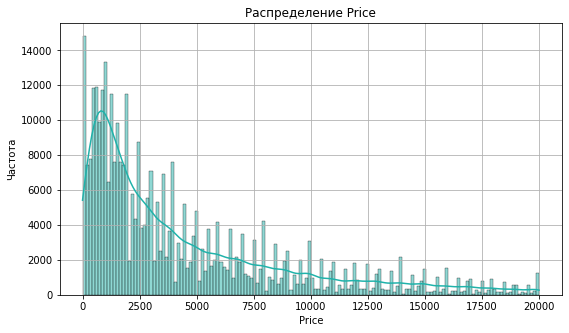

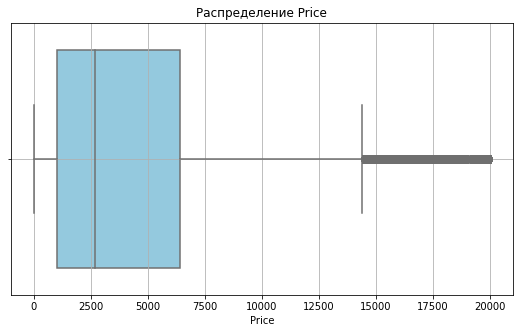

In [ ]:
plot_distribution (df, 'Price',bins=150)

#### Анализ месяца регистрации автомобиля

In [ ]:
df['RegistrationYear'].describe()

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [ ]:
df = df[df['RegistrationYear'].between(1980, 2016)]

In [ ]:
df.shape

(336383, 15)

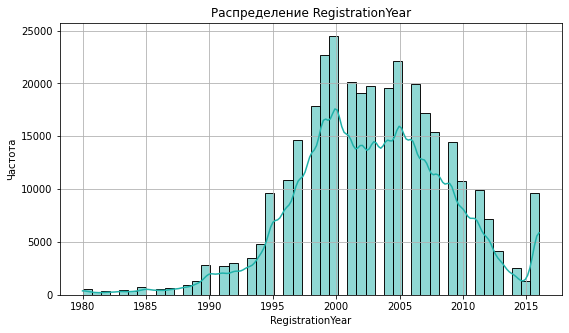

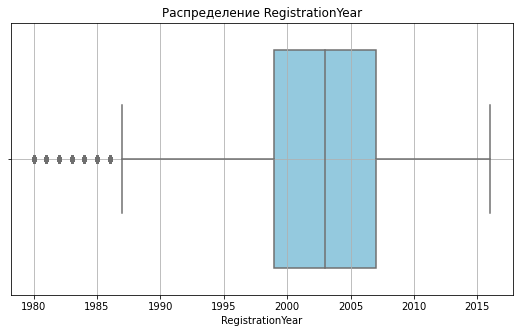

In [ ]:
plot_distribution (df, 'RegistrationYear', bins=50)

In [ ]:
df['RegistrationYear'].describe()

count    336383.000000
mean       2002.828912
std           6.082015
min        1980.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод: Аномальные значения в столбце были удалены, больше всего представлено автомобилей примерно с 1998 по 2006 год .</p>
</div>

#### Анализ мощности (л. с.)

In [ ]:
df['Power'].describe()

count    336383.000000
mean        111.366439
std         185.511186
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [ ]:
df = df[df['Power'].between(64, 400)]

In [ ]:
df.shape

(262062, 15)

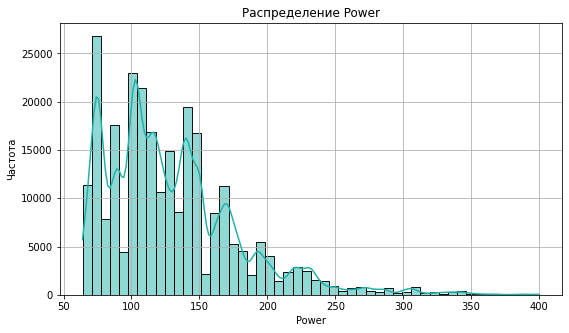

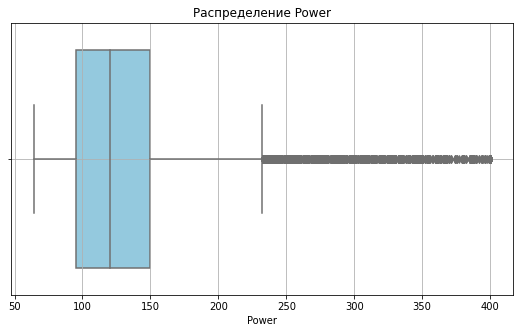

In [ ]:
plot_distribution (df, 'Power', bins=50)

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод: Аномальные значения в столбце были удалены, больше всего представлено автомобилей с мощностью в диапозоне от 64 до 100, на графике в этом диапозоне расположен пик  .</p>
</div>

#### Анализ пробега(км)

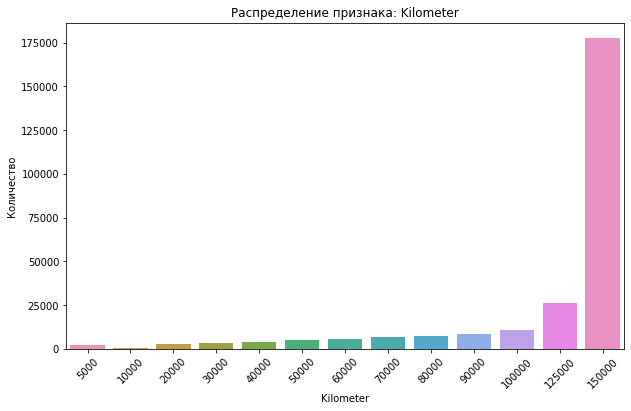

In [ ]:
def plot_discrete(df, feature):
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=feature)
        plt.title(f'Распределение признака: {feature}')
        plt.xlabel(feature)
        plt.ylabel('Количество')
        plt.xticks(rotation=45)
        plt.show()


plot_discrete(df, 'Kilometer')

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод: Поскольку в нашем датасете представлены разные автомобили, с разными годами эксплуатации, не удивительно что пробег для б/у автомобилей будет иметь такой разбросс, сложно сказать какие данные в нашем случае можно считать аномальными.</p>
</div>

#### Анализ месяца регистрации автомобиля

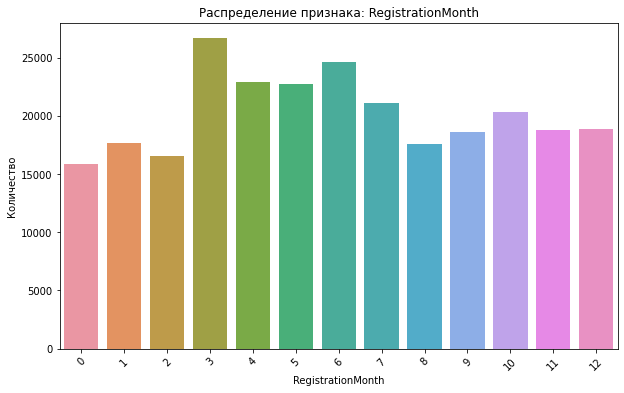

In [ ]:
plot_discrete(df, 'RegistrationMonth')

In [ ]:
df = df[df['RegistrationMonth'].between(1, 12)]

In [ ]:
df.shape

(246237, 15)

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод: Аномальные значения в виде нулевого месяца удалены</p>
</div>

#### Анализ  даты создания анкеты

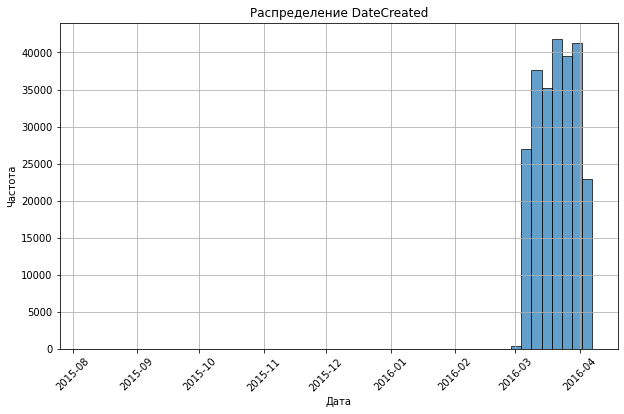

Первая дата - 2015-08-07 00:00:00  Последняя дата - 2016-04-07 00:00:00


In [ ]:
def plot_date(df, date_column, bins=50):

    plt.figure(figsize=(10, 6))
    plt.hist(df[date_column], bins=bins, edgecolor='k', alpha=0.7)
    plt.title(f"Распределение {date_column}")
    plt.xlabel("Дата")
    plt.ylabel("Частота")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    first_date = df[date_column].min()
    last_date = df[date_column].max()
    print(f"Первая дата - {first_date}  Последняя дата - {last_date}")


plot_date(df, 'DateCreated')

In [ ]:
df.shape

(246237, 15)

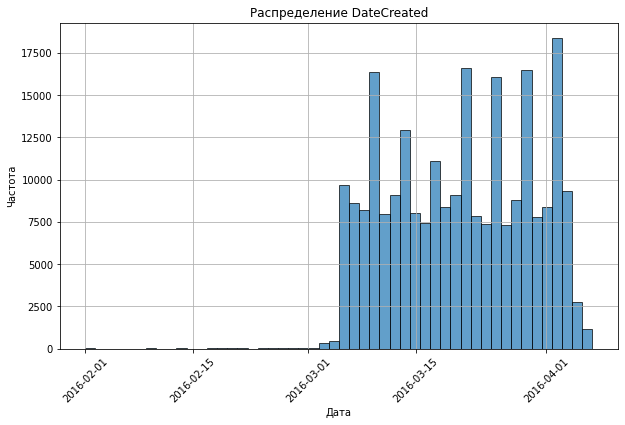

Первая дата - 2016-02-01 00:00:00  Последняя дата - 2016-04-07 00:00:00


In [ ]:
df = df[df['DateCreated'] >= pd.Timestamp('2016-02-01')]

plot_date(df, 'DateCreated')

In [ ]:
df.shape

(246161, 15)

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод: Аномальные значения были удалены, на представленном графике видно, что в основном анкеты создавались с 2016-03-01 по 2016-04-07 </p>
</div>

#### Анализ даты скачивания анкеты из базы

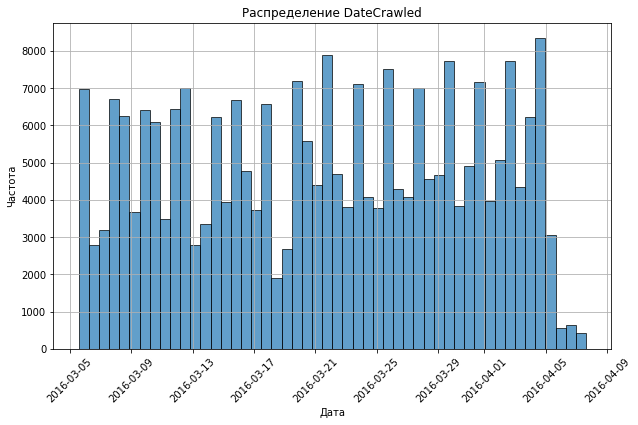

Первая дата - 2016-03-05 14:06:22  Последняя дата - 2016-04-07 14:36:58


In [ ]:
plot_date(df, 'DateCrawled')

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод: Анкеты скачивались с 2016-03-05 по 2016-04-07 </p>
</div>

#### Анализ даты последней активности пользователя

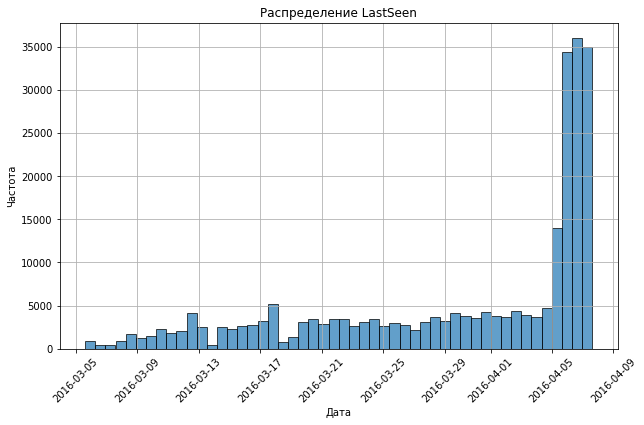

Первая дата - 2016-03-05 14:15:08  Последняя дата - 2016-04-07 14:58:51


In [ ]:
plot_date(df, 'LastSeen')

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод: Наиболее активные пользователи были с 2016-04-05 по 2016-04-07</p>
</div>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246161 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        246161 non-null  datetime64[ns]
 1   Price              246161 non-null  int64         
 2   VehicleType        246161 non-null  object        
 3   RegistrationYear   246161 non-null  int64         
 4   Gearbox            246161 non-null  object        
 5   Power              246161 non-null  int64         
 6   Model              246161 non-null  object        
 7   Kilometer          246161 non-null  int64         
 8   RegistrationMonth  246161 non-null  int64         
 9   FuelType           246161 non-null  object        
 10  Brand              246161 non-null  object        
 11  Repaired           246161 non-null  object        
 12  DateCreated        246161 non-null  datetime64[ns]
 13  PostalCode         246161 non-null  int64   

### Анализ категориальных данных

In [ ]:
def explore_cat_columns(df,cat_columns):

    for column in cat_columns:
        print(f"Анализ категориального столбца '{column}':")
        print("Уникальные значения:")
        print(df[column].unique())
        print("Количество уникальных значений:", len(df[column].unique()))
        print("Распределение значений:")
        print(df[column].value_counts())
        plt.figure(figsize=(10, 6))
        sns.countplot(data=df, x=column, order=df[column].value_counts().index, palette='pastel')
        plt.title(f'Распределение значений в столбце {column}')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.show()
        print("\n")

Анализ категориального столбца 'VehicleType':
Уникальные значения:
['coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Количество уникальных значений: 8
Распределение значений:
sedan          77718
wagon          56344
small          37890
bus            25063
convertible    17090
coupe          13140
suv            10463
other           8453
Name: VehicleType, dtype: int64


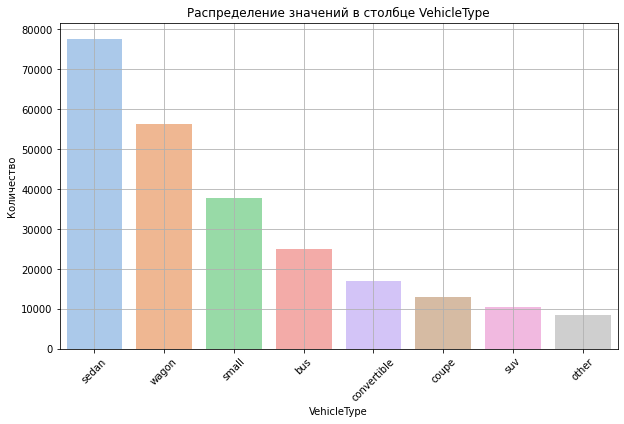



Анализ категориального столбца 'Gearbox':
Уникальные значения:
['manual' 'auto' 'other']
Количество уникальных значений: 3
Распределение значений:
manual    189654
auto       53753
other       2754
Name: Gearbox, dtype: int64


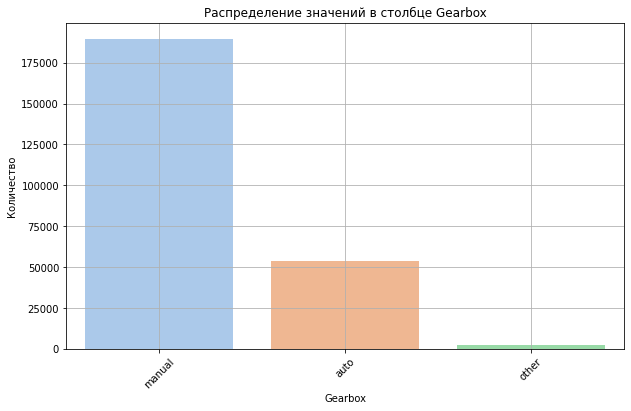



Анализ категориального столбца 'FuelType':
Уникальные значения:
['petrol' 'other' 'lpg' 'hybrid' 'cng' 'electric']
Количество уникальных значений: 6
Распределение значений:
petrol      231689
other         9469
lpg           4344
cng            435
hybrid         198
electric        26
Name: FuelType, dtype: int64


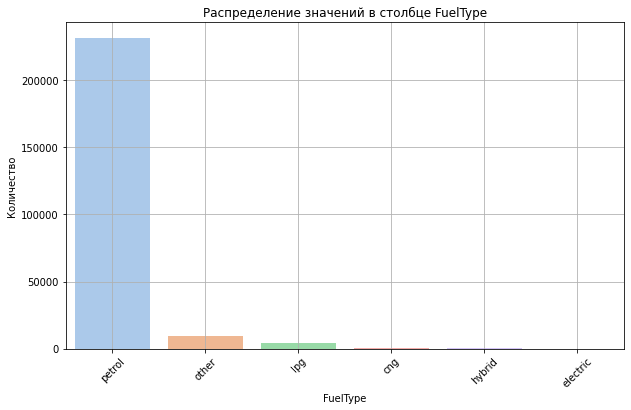



Анализ категориального столбца 'Repaired':
Уникальные значения:
['yes' 'other' 'no']
Количество уникальных значений: 3
Распределение значений:
no       194544
other     28939
yes       22678
Name: Repaired, dtype: int64


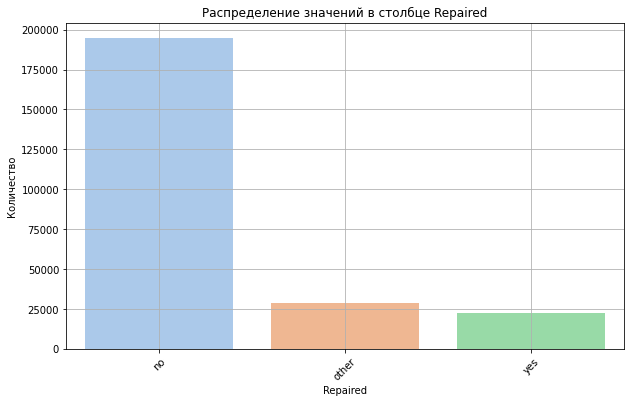

In [ ]:
cat_columns = ['VehicleType','Gearbox','FuelType','Repaired']
explore_cat_columns(df,cat_columns)

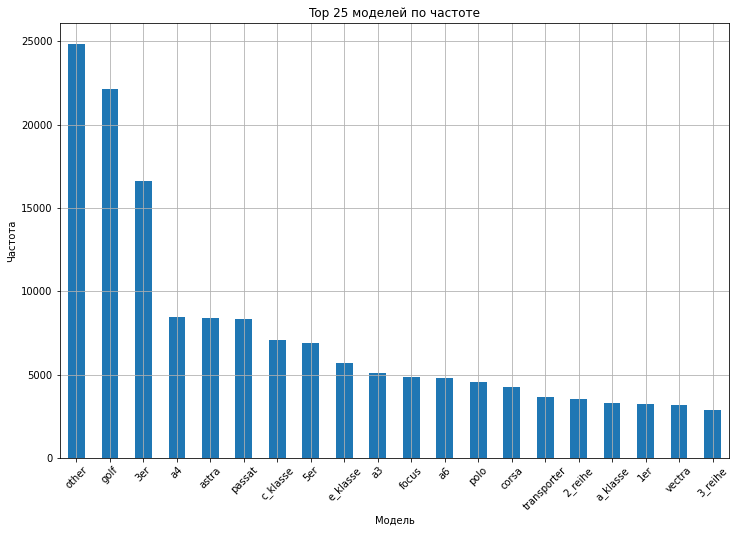

In [ ]:
model_counts = df['Model'].value_counts()
top_20_models = model_counts.nlargest(20)

plt.figure(figsize=(12, 8))
top_20_models.plot(kind='bar')
plt.title('Top 25 моделей по частоте')
plt.xlabel('Модель')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

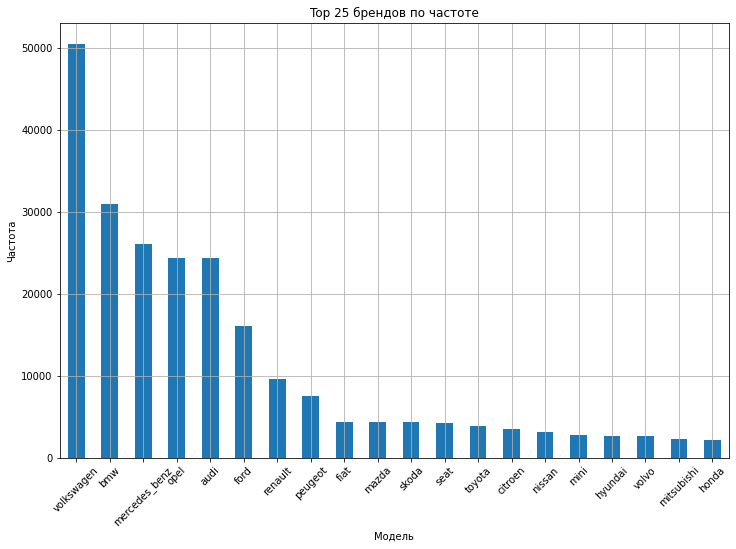

In [ ]:
brand_counts = df['Brand'].value_counts()
top_20_models = brand_counts.nlargest(20)

plt.figure(figsize=(12, 8))
top_20_models.plot(kind='bar')
plt.title('Top 25 брендов по частоте')
plt.xlabel('Модель')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод:
    <ul>
    <li><strong>VehicleType</strong> — больше всего автомобилей с типом кузова седан</li>
    <li><strong>Gearbox</strong> — больше всего автомобилей с механической коробкой передач</li>
    <li><strong>Model</strong> — больше всего автомобилей в категории "другие модели", но самой популярной моделью является Golf</li>
    <li><strong>FuelType</strong> — подавляющее большинство машин на бензиновом топливе</li>
    <li><strong>Brand</strong> — самая популярная марка автомобиля Volkswagen</li>
    <li><strong>Repaired</strong> — большинство пользователей отмечают, что автомобиль не был в ремонте</li>
</ul> </p>
</div>

## Корреляционный анализ

In [ ]:
columns_list = df.columns.difference(['PostalCode','DateCrawled' , 'DateCreated', 'LastSeen'])

correlation_matrix = df[columns_list].phik_matrix(
    interval_cols=['Power ','Price'])

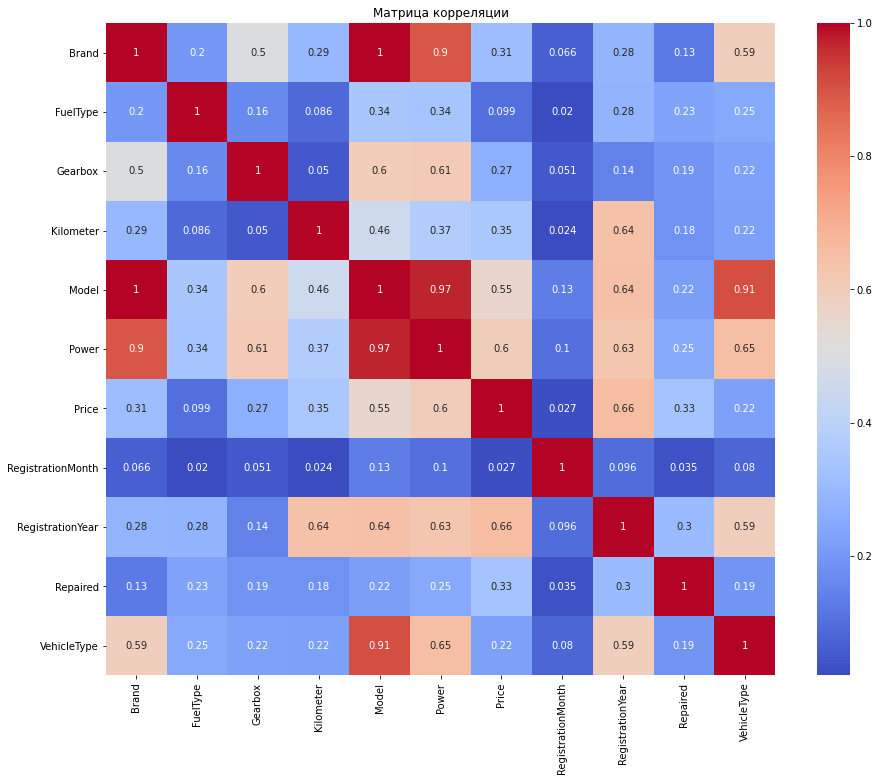

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show()

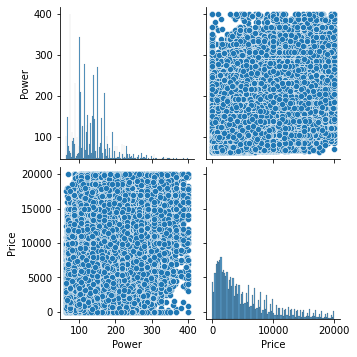

In [ ]:
numerical_features = df[['Power','Price']]
sns.pairplot(numerical_features, palette='Set1')
plt.show()

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
    Вывод: Бренд и модель автомобиля полностью коррелируют между собой, что является логичным. Рассмотрим важность наличия обоих этих столбцов и возможность использования только одного из них для обучения модели или их объединения. При использовании линейных моделей возможно возникновение проблемы мультиколлинеарности.
    
Целевой признак сильно коррелирует с годом регистрации, моделью и мощностью автомобиля. Умеренная корреляция наблюдается с брендом, пробегом и наличием ремонтов. Остальные признаки демонстрируют слабую корреляцию с целевым признаком.</p>
</div>

## Подготовка данных

<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
<p>
   Поскольку даты создания анкет и другие признаки с датами ('DateCrawled', 'DateCreated', 'LastSeen') в данном датафрейме не имеют влияние на ценообразование, удалим эти колонки.</p>
</div>

In [ ]:
col = ['DateCrawled', 'DateCreated', 'LastSeen','PostalCode','RegistrationMonth']
df_ml = df.drop(df[col], axis=1)

In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246161 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             246161 non-null  int64 
 1   VehicleType       246161 non-null  object
 2   RegistrationYear  246161 non-null  int64 
 3   Gearbox           246161 non-null  object
 4   Power             246161 non-null  int64 
 5   Model             246161 non-null  object
 6   Kilometer         246161 non-null  int64 
 7   FuelType          246161 non-null  object
 8   Brand             246161 non-null  object
 9   Repaired          246161 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.7+ MB


In [ ]:
df_ml['BrandModel'] = df_ml.apply(lambda row: row['Brand'] + ' ' + row['Model'], axis=1)
col = ['Brand', 'Model']
df_ml = df_ml.drop(df_ml[col], axis=1)
df_ml.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,Repaired,BrandModel
1,18300,coupe,2011,manual,190,125000,petrol,yes,audi other
2,9800,suv,2004,auto,163,125000,petrol,other,jeep grand
3,1500,small,2001,manual,75,150000,petrol,no,volkswagen golf
4,3600,small,2008,manual,69,90000,petrol,no,skoda fabia
5,650,sedan,1995,manual,102,150000,petrol,yes,bmw 3er


In [ ]:
duplicates_df(df_ml,'df_ml')

Обнаружено 31984 явных дубликатов для df_ml.


In [ ]:
df_ml.drop_duplicates(inplace=True)
duplicates_df(df_ml,'df_ml')

Явных дубликатов для df_ml не обнаружено.


In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214177 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             214177 non-null  int64 
 1   VehicleType       214177 non-null  object
 2   RegistrationYear  214177 non-null  int64 
 3   Gearbox           214177 non-null  object
 4   Power             214177 non-null  int64 
 5   Kilometer         214177 non-null  int64 
 6   FuelType          214177 non-null  object
 7   Repaired          214177 non-null  object
 8   BrandModel        214177 non-null  object
dtypes: int64(4), object(5)
memory usage: 16.3+ MB


In [ ]:
ohe_columns = ['VehicleType', 'Gearbox', 'BrandModel','FuelType','Repaired']
num_columns = ['RegistrationYear', 'Power','Kilometer']

In [ ]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')


pipe_final_dt = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])


pipe_final_cb = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostRegressor(logging_level='Silent',random_state=RANDOM_STATE))
])

In [ ]:
pipe_final_lgb = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state=RANDOM_STATE))
])

pipe_final_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

param_grid_dt = {
    'models__max_depth':  range(2, 11),
    'models__min_samples_split':  range(2, 11),
    'models__min_samples_leaf':  range(2, 11),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

param_grid_cb = {
    'models__depth': range(2, 4),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}

param_grid_lgb = {
    'models__n_estimators': [25, 50, 100],
    'models__max_depth': range(2, 4),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']}

param_grid_lr = {
    'models__fit_intercept': [True, False],
    'models__copy_X': [True, False],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

In [ ]:
X = df_ml.drop(['Price'], axis=1)
y= df_ml['Price']
X.shape, y.shape

((214177, 8), (214177,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

## Обучение моделей

In [ ]:
%%time
randomized_search_dt = RandomizedSearchCV(
    pipe_final_dt,
    param_grid_dt,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search_dt.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search_dt.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_dt.best_score_)

In [ ]:
%%time
randomized_search_lgb = RandomizedSearchCV(
    pipe_final_lgb,
    param_grid_lgb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search_lgb.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search_lgb.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_lgb.best_score_)

In [ ]:
%%time
randomized_search_cb = RandomizedSearchCV(
    pipe_final_cb,
    param_grid_cb,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search_cb.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search_cb.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_cb.best_score_)

In [ ]:
%%time
randomized_search_lr = RandomizedSearchCV(
    pipe_final_lr,
    param_grid_lr,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

randomized_search_lr.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search_lr.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', randomized_search_lr.best_score_)

## Анализ моделей

In [ ]:
model_dt = DecisionTreeRegressor(max_depth=10, min_samples_leaf=10, min_samples_split=5, random_state=RANDOM_STATE)

model_cb = CatBoostRegressor(logging_level='Silent', depth=3, random_state=RANDOM_STATE)

model_lgb = LGBMRegressor(force_row_wise=True, max_depth=3, n_estimators=50, random_state=RANDOM_STATE)

model_lr = LinearRegression()

def evaluate_model(model, data_preprocessor, X_train, y_train):
    pipe = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', model)
    ])

    kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    start_train = time.time()
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=kf, scoring='neg_mean_squared_error')
    end_train = time.time()

    pipe.fit(X_train, y_train)
    start_predict = time.time()
    pipe.predict(X_train)
    end_predict = time.time()

    train_time = end_train - start_train
    predict_time = end_predict - start_predict
    rmse = np.sqrt(-cv_scores.mean())

    return train_time, predict_time, rmse

models = {
    'Decision Tree': model_dt,
    'CatBoost': model_cb,
    'LightGBM': model_lgb,
    'LinearRegression': model_lr
}

results = []

for model_name, model in models.items():
    train_time, predict_time, rmse = evaluate_model(model, data_preprocessor, X_train, y_train)
    results.append([model_name, train_time, predict_time, rmse])


results_df = pd.DataFrame(results, columns=["Модель", "Время обучения(сек)", "Время предсказания (сек)", "RMSE"])
results_df

,Модель,Время обучения(сек),Время предсказания (сек),RMSE
0,Decision Tree,9.504499,0.385908,2164.973152
1,CatBoost,71.711383,0.605754,1886.330543
2,LightGBM,9.992259,0.607897,2229.459622
3,LinearRegression,105.253791,0.518888,2590.057889


<div style="border: 2px solid #DABDAB; border-radius: 5px; padding: 10px; color: #45322E; background-color#FFF0FC;">
    <p>Проанализировав таблицу, можно сделать вывод, что модель, которая удовлетворяет потребности заказчика, это Decision Tree </p>
</div>

In [ ]:
pipe = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', model_dt)
])

start_train = time.time()
pipe.fit(X_test, y_test)
end_train = time.time()

start_predict = time.time()
y_pred = pipe.predict(X_test)
end_predict = time.time()

train_time = end_train - start_train
predict_time = end_predict - start_predict

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Время обучения модели: {train_time:.4f} секунд")
print(f"Время предсказания: {predict_time:.4f} секунд")
print(f"RMSE на тестовых данных: {rmse:.4f}")

Время обучения модели: 0.6827 секунд
Время предсказания: 0.1161 секунд
RMSE на тестовых данных: 2088.5657


In [ ]:
dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(X_train, y_train)
y_dummy_pred = dummy_model.predict(X_test)

rmse_dummy = np.sqrt(mean_squared_error(y_test, y_dummy_pred))

print(f"Время обучения модели: {train_time:.4f} секунд")
print(f"Время предсказания: {predict_time:.4f} секунд")
print(f"RMSE на тестовых данных (модель): {rmse:.4f}")
print(f"RMSE на тестовых данных (константная модель): {rmse_dummy:.4f}")

if rmse < rmse_dummy:
    print("Наша модель лучше константной модели.")
else:
    print("Наша модель не лучше константной модели. Возможно, стоит пересмотреть подход.")

Время обучения модели: 0.6827 секунд
Время предсказания: 0.1161 секунд
RMSE на тестовых данных (модель): 2088.5657
RMSE на тестовых данных (константная модель): 4776.3074
Наша модель лучше константной модели.


## Общий вывод

<div style="border: 2px solid #87CEEB; border-radius: 5px; padding: 10px; color: #45322E; background-color#B0E0E6;">
Проект направлен на разработку модели для сервиса по продаже подержанных автомобилей "Не бит, не крашен". Целью модели является предсказание рыночной стоимости автомобиля на основе его технических характеристик и комплектации.

<strong>Этапы проекта:</strong>
<ol>
    <li><strong>Изучение данных и предобработка:</strong>
        <ul>
            <li>Были загружены и изучены данные, обнаружены пропущенные значения и аномалии.</li>
            <li>Произведена обработка пропусков, удаление неинформативных признаков и аномалий.</li>
            <li>Объеденены столбцы с моделями и брендами автомобилей.</li>
        </ul>
    </li>

   <li><strong>Подготовка выборок для обучения моделей:</strong>
        <ul>
            <li>Данные были подготовлены для обучения моделей с помощью масштабирования числовых признаков, кодирования категориальных признаков.</li>
            <li>Удалены неинформативные столбцы.</li>
        </ul>
    </li>

   <li><strong>Обучение и сравнение моделей:</strong>
        <ul>
            <li>Были обучены разные модели, включая Градиентный бустинг(LightGBM, CatBoost), дерево решений и линейную регрессию.</li>
            <li>Проведено сравнение моделей по метрикам качества (RMSE), времени обучения и времени предсказания.</li>
        </ul>
    </li>

   <li><strong>Выбор наилучшей модели:</strong>
        <ul>
            <li>На основании критериев заказчика (качество предсказания, время обучения и предсказания) выбрана оптимальная модель.</li>
            <li>Модель дерева решения (Decision Tree) показала лучшие результаты с RMSE ниже 2500 и самым быстрым временем обучения на тренировочной выборке, что соответствует требованиям к точности предсказания.
        </ul>
    </li>
</ol>

<strong>Вывод:</strong>

Проект показал, что модель Decision Tree является наилучшим выбором для внедрения. Она обеспечивает высокую точность предсказания за разумное время обучения и предсказания. Рекомендуется использовать модель Decision Tree для дальнейшей разработки и внедрения в сервис по оценке рыночной стоимости подержанных автомобилей "Не бит, не крашен".
</div>